In [1]:
# imports
%load_ext autoreload
%autoreload 2
from timeit import default_timer as timer
from victor_thesis_experiments import *
from victor_thesis_utils import *
from victor_thesis_landscapes import *
from victor_thesis_plots import *
from victor_thesis_metrics import *

starting
done


In [2]:
# test n-dim landscape generation

# hadamard U2
qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
unitary = torch.tensor(np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu")
############
# phase R
# qnn = get_qnn("CudaR", list(range(1)), 1, device="cpu")
# unitary = torch.tensor(np.array([[1, 0], [0, 1j]]), dtype=torch.complex128, device="cpu")
############
num_ticks = 100
data_points = 20
# generate data points
non_entangled_inputs = generate_random_datapoints(data_points, 1, unitary)
# print("starting small tests")
# # actual 3d qnn vs 2d qnn with same tick number
# n_2d_ticks = 353
# start = timer()
# loss_nd, _ = generate_loss_landscape(n_2d_ticks,2, non_entangled_inputs, unitary, qnn)
# end = timer() 
# print(f"2d gen with* {n_2d_ticks**2} points: {np.round(end-start,3)}s")

# qnn = get_qnn("CudaPennylane", list(range(1)), 1, device="cpu")
# n_3d_ticks = 50
# start = timer()
# loss_nd, _ = generate_loss_landscape(n_3d_ticks,3, non_entangled_inputs, unitary, qnn)
# end = timer() 
# print(f"3d gen with {n_3d_ticks**3} points: {np.round(end-start,3)}s")

# multi dim and tick tests
qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
print("starting full tests")
dimensions_tests = [2, 3, 4, 5, 6, 7, 8, 9]
num_ticks_tests = [3, 5, 7, 10, 15, 20]
for dimensions in dimensions_tests:
    print(f"{dimensions} PARAMS")
    for ticks in num_ticks_tests:    
        start = timer()
        landscape, _= generate_loss_landscape(ticks,dimensions, non_entangled_inputs, unitary, qnn)    
        end = timer()        
        print(f"time for landscape generation with {dimensions} params and {ticks} ticks ({ticks**dimensions} points): {np.round(end-start,3)}s")
        start = timer()
        calc_scalar_curvature(landscape)  
        end = timer()        
        print(f"time for scalar curvature calculation: {np.round(end-start,3)}s")
        start = timer()
        calc_total_variation(landscape)  
        calc_IGSD(landscape)
        calc_fourier_density(landscape) 
        end = timer()        
        print(f"time for all other metrics: {np.round(end-start,3)}s")
        print("-----")
    print("##############################################################################")
    print("##############################################################################")
    print("##############################################################################")
#test 3d stuff


#plot_scatter_of_U3(loss_3d, points_non_ent, num_ticks)
#plot_scatter_of_U3(loss_nd, points_non_ent, num_ticks)

starting full tests
2 PARAMS
time for landscape generation with 2 params and 3 ticks (9 points): 0.003s
time for scalar curvature calculation: 0.0s
time for all other metrics: 0.0s
-----
time for landscape generation with 2 params and 5 ticks (25 points): 0.005s
time for scalar curvature calculation: 0.001s
time for all other metrics: 0.0s
-----
time for landscape generation with 2 params and 7 ticks (49 points): 0.008s
time for scalar curvature calculation: 0.001s
time for all other metrics: 0.0s
-----
time for landscape generation with 2 params and 10 ticks (100 points): 0.017s
time for scalar curvature calculation: 0.001s
time for all other metrics: 0.0s
-----
time for landscape generation with 2 params and 15 ticks (225 points): 0.039s
time for scalar curvature calculation: 0.004s
time for all other metrics: 0.0s
-----
time for landscape generation with 2 params and 20 ticks (400 points): 0.076s
time for scalar curvature calculation: 0.007s
time for all other metrics: 0.0s
-----
##

c:\Users\Gamer\Repositories\master-thesis\Code\entangled_qnn_training-main\victor_thesis_metrics.py:81: RuntimeWarning: divide by zero encountered in divide
  inverse_gradient_standard_deviations = np.divide(1, gradient_standard_deviations)


time for landscape generation with 3 params and 7 ticks (343 points): 0.063s
time for scalar curvature calculation: 0.006s
time for all other metrics: 0.001s
-----
time for landscape generation with 3 params and 10 ticks (1000 points): 0.174s
time for scalar curvature calculation: 0.018s
time for all other metrics: 0.001s
-----
time for landscape generation with 3 params and 15 ticks (3375 points): 0.627s
time for scalar curvature calculation: 0.069s
time for all other metrics: 0.005s
-----
time for landscape generation with 3 params and 20 ticks (8000 points): 1.441s
time for scalar curvature calculation: 0.155s
time for all other metrics: 0.007s
-----
##############################################################################
##############################################################################
##############################################################################
4 PARAMS
time for landscape generation with 4 params and 3 ticks (81 points): 0.015s
time for scalar 

In [ ]:
# n-dim tests
def n_dim_tests(
):
    qnn = get_qnn("CudaPennylane", list(range(1)), 1, device="cpu")
    unitary = torch.tensor(
        np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu"
    )
    num_ticks = 12
    # generate data points
    non_entangled_inputs = generate_random_datapoints(5, 1, unitary)
    entangled_inputs = generate_random_datapoints(5, 2, unitary)
    z_o_inputs = get_zero_one_datapoints()
    # get 3d landscapes
    loss_z_o_3d= generate_3D_loss_landscape(
        num_ticks, z_o_inputs, unitary
    )
    loss_non_ent_3d= generate_3D_loss_landscape(
        num_ticks, non_entangled_inputs, unitary
    )
    loss_ent_3d= generate_3D_loss_landscape(
        num_ticks, entangled_inputs, unitary
    )
    landscapes = [loss_z_o_3d, loss_non_ent_3d, loss_ent_3d]
    #test total variation
    print(
        "TOTAL VARIATION: ",
        calc_total_variation(landscapes[0]),
        calc_total_variation(landscapes[1]),
        calc_total_variation(landscapes[2]),
    )
    #test igsd
    for landscape in landscapes:
        igsd = calc_IGSD(landscape)
        count = 1
        for sd in igsd:
            print(f"IGSD (dir {count}): {sd}")
            count +=1
        print("---------")
    #test fourier stuff
    print("fourier densities:")
    print(calc_fourier_density(landscapes[0]))
    print(calc_fourier_density(landscapes[1]))
    print(calc_fourier_density(landscapes[2]))

    #test scalar curvature
    print("---------")
    print("Scalar curvature absolute sums: ")
    for landscape in landscapes:
        print(np.sum(np.absolute(calc_scalar_curvature(landscape))))
    
n_dim_tests()

In [ ]:
# n-dim tests 2d
qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
unitary = torch.tensor(
    np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu"
)
num_ticks = 12
# generate data points
non_entangled_inputs = generate_random_datapoints(5, 1, unitary)
entangled_inputs = generate_random_datapoints(5, 2, unitary)
z_o_inputs = get_zero_one_datapoints()
# get 3d landscapes
loss_z_o_3d= generate_2d_loss_landscape(
    num_ticks, z_o_inputs, unitary, qnn
)
loss_non_ent_3d= generate_2d_loss_landscape(
    num_ticks, non_entangled_inputs, unitary, qnn
)
loss_ent_3d= generate_2d_loss_landscape(
    num_ticks, entangled_inputs, unitary, qnn
)
landscapes = [loss_z_o_3d, loss_non_ent_3d, loss_ent_3d]
#test scalar curvature
# print(get_scalar_curvature(landscapes[0]))
# get_scalar_curvature(landscapes[1])
# get_scalar_curvature(landscapes[2])
#test total variation
print(
    "TOTAL VARIATION: ",
    calc_total_variation(landscapes[0]),
    calc_total_variation(landscapes[1]),
    calc_total_variation(landscapes[2]),
)
#test igsd
for landscape in landscapes:
    igsd = calc_IGSD(landscape)
    count = 1
    for sd in igsd:
        print(f"IGSD (dir {count}): {sd}")
        count +=1
    print("---------")
#test fourier stuff
print("fourier stuff")
fourier_landscape_z_o = get_fourier_landscape(z_o_inputs, unitary, qnn)
fourier_landscape_non_entangled = get_fourier_landscape(non_entangled_inputs, unitary, qnn)
fourier_landscape_entangled = get_fourier_landscape(entangled_inputs, unitary, qnn)
print(calc_fourier_density(landscapes[0]))
print(calc_fourier_density(landscapes[1]))
print(calc_fourier_density(landscapes[2]))
#test scalar curvature
for landscape in landscapes:
    print("SC: ",np.sum(np.absolute(calc_scalar_curvature(landscape))))

fourier stuff
different versions of calculating fourier density - not sure which one is the correct one?
FD lib with np linalg norms: 3.599
FD lib with semi custom norms: 3.599
FD lib with full custom norms: 3.599
FD manual custom: 2.667
different versions of calculating fourier density - not sure which one is the correct one?
FD lib with np linalg norms: 1.847
FD lib with semi custom norms: 5.746
FD lib with full custom norms: 5.304
FD manual custom: 3.625
different versions of calculating fourier density - not sure which one is the correct one?
FD lib with np linalg norms: 1.703
FD lib with semi custom norms: 4.725
FD lib with full custom norms: 4.547
FD manual custom: 3.489


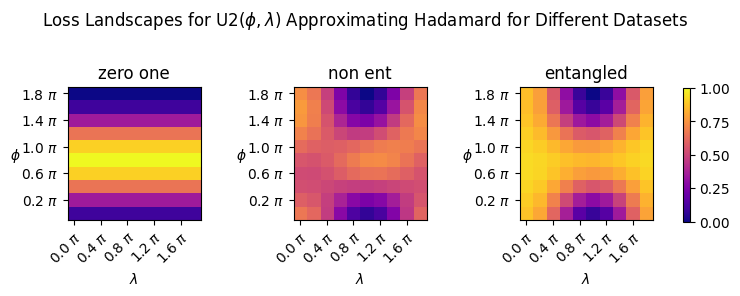

real values


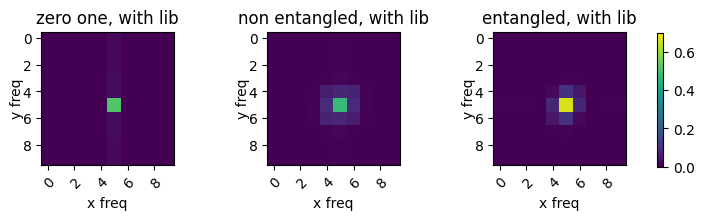

absolute sum:  3.066031375677082


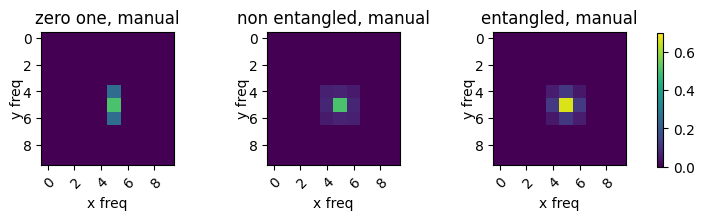

absolute sum:  3.318738607606764
imaginary values


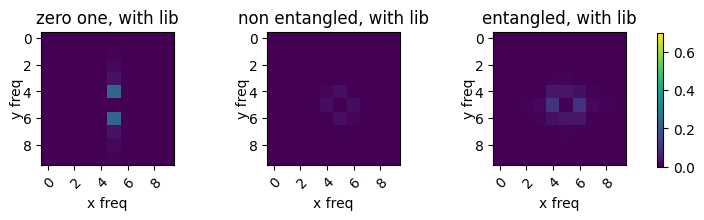

absolute sum:  1.3032783765217895


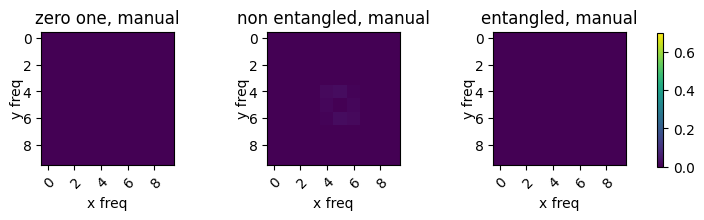

absolute sum:  0.12361267541579875
sum of real and imaginary values


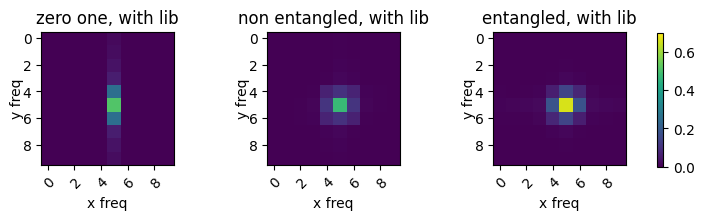

absolute sum:  4.369309752198871


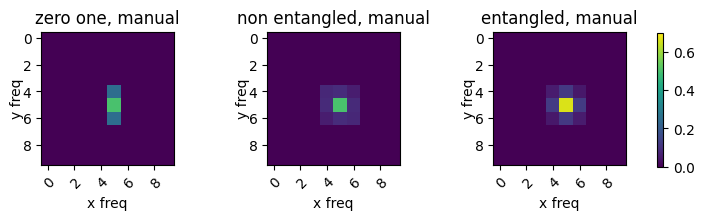

absolute sum:  3.442351283022562


In [5]:
# fourier testing

# hadamard U2
qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
unitary = torch.tensor(np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu")
############
# phase R
# qnn = get_qnn("CudaR", list(range(1)), 1, device="cpu")
# unitary = torch.tensor(np.array([[1, 0], [0, 1j]]), dtype=torch.complex128, device="cpu")
############
num_ticks = 10
# generate data points
non_entangled_inputs = generate_random_datapoints(5, 1, unitary)
entangled_inputs = generate_random_datapoints(5, 2, unitary)
z_o_inputs = get_zero_one_datapoints()
# get 2d landscapes
loss_z_o= generate_2d_loss_landscape(
    num_ticks, z_o_inputs, unitary, qnn
)
loss_non_ent= generate_2d_loss_landscape(
    num_ticks, non_entangled_inputs, unitary, qnn
)
loss_ent= generate_2d_loss_landscape(
    num_ticks, entangled_inputs, unitary, qnn
)
landscapes = [loss_z_o, loss_non_ent, loss_ent]

#test fourier stuff
print("fourier stuff")
fourier_landscape_z_o = get_fourier_landscape(z_o_inputs, unitary, qnn,num_ticks).values
z_o_fd, z_o_f_plot = calc_fourier_density(landscapes[0])
print("FD manual custom:", z_o_fd)
fourier_landscape_non_entangled = get_fourier_landscape(non_entangled_inputs, unitary, qnn,num_ticks).values
n_e_fd, non_ent_f_plot = calc_fourier_density(landscapes[1])
print("FD manual custom:", n_e_fd)
fourier_landscape_entangled = get_fourier_landscape(entangled_inputs, unitary, qnn,num_ticks).values
e_fd, ent_f_plot = calc_fourier_density(landscapes[2])
print("FD manual custom:", e_fd)

# differences possibly explained by different loss landscape sampling
plot_row(landscapes, ["zero one", "non ent","entangled"], "Hadamard", "U2", mode="default")
print("real values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).real), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).real)))

print("imaginary values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).imag), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).imag)))

print("sum of real and imaginary values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)+np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)+np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).imag)+np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).real), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).imag)+np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).real)))
# print(calc_fourier_density(landscapes[0]))
# print(calc_fourier_density(landscapes[1]))
# print(calc_fourier_density(landscapes[2]))


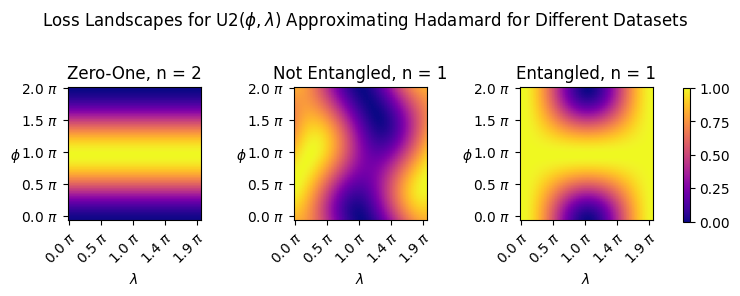

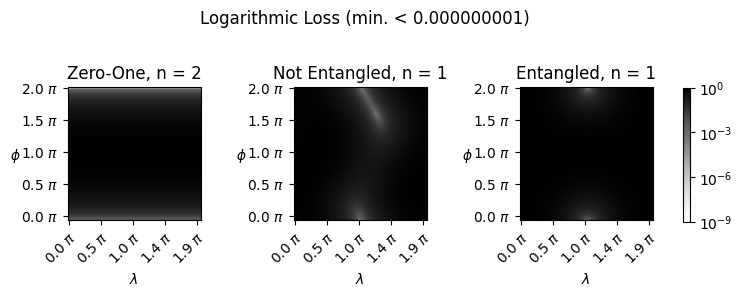

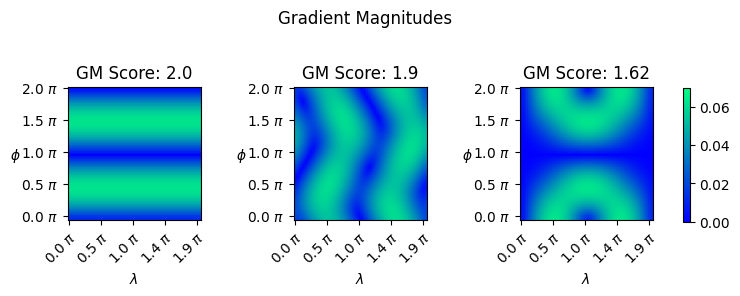

TOTAL VARIATION:  12.57 15.41 12.57
IGSD (dir 1):  22.56
IGSD (dir 2):  1.4927336302911796e+16
---------
IGSD (dir 1):  55.04
IGSD (dir 2):  27.05
---------
IGSD (dir 1):  36.83
IGSD (dir 2):  36.83
---------
Frequency Domain for Plot 3
different versions of calculating fourier density - not sure which one is the correct one?
FD lib with np linalg norms: 2.844
FD lib with semi custom norms: 2.844
FD lib with full custom norms: 2.844
FD3 2.667
different versions of calculating fourier density - not sure which one is the correct one?
FD lib with np linalg norms: 1.169
FD lib with semi custom norms: 5.188
FD lib with full custom norms: 4.962
FD3 4.447
different versions of calculating fourier density - not sure which one is the correct one?
FD lib with np linalg norms: 1.705
FD lib with semi custom norms: 4.014
FD lib with full custom norms: 3.847
FD3 3.512


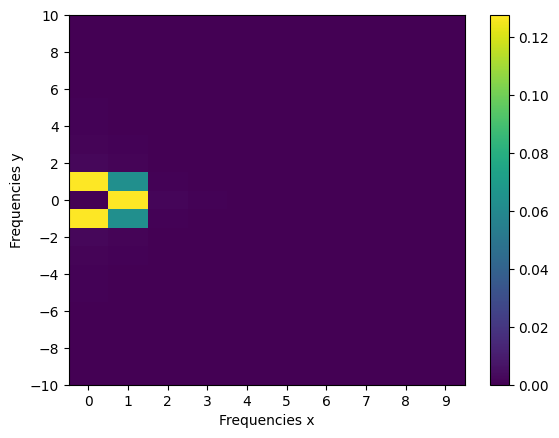

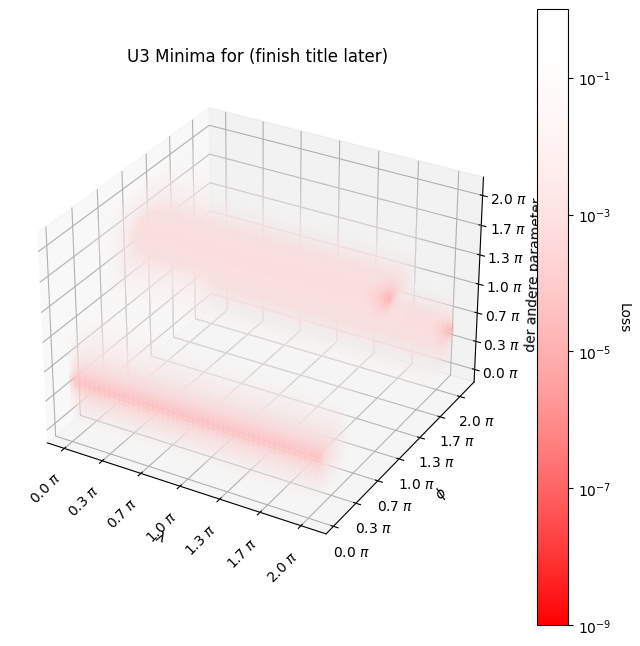

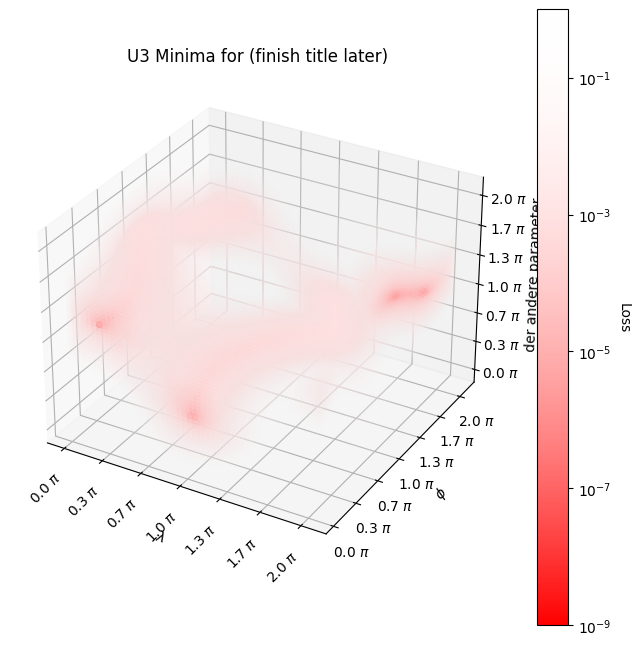

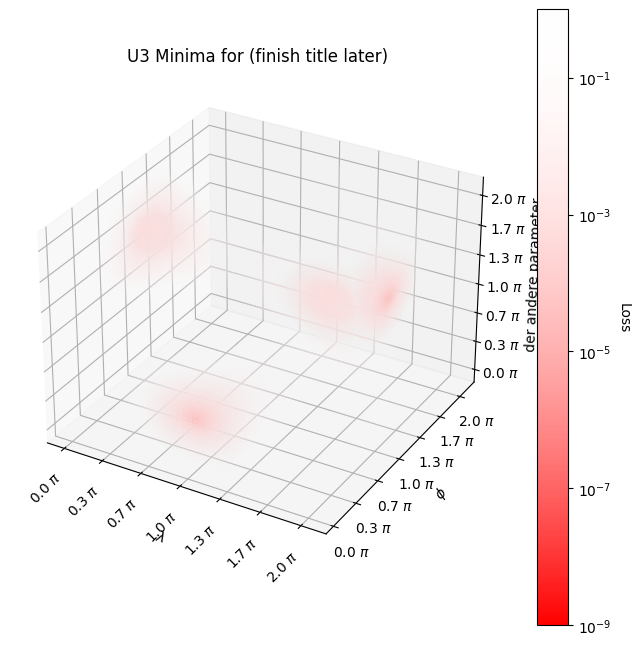

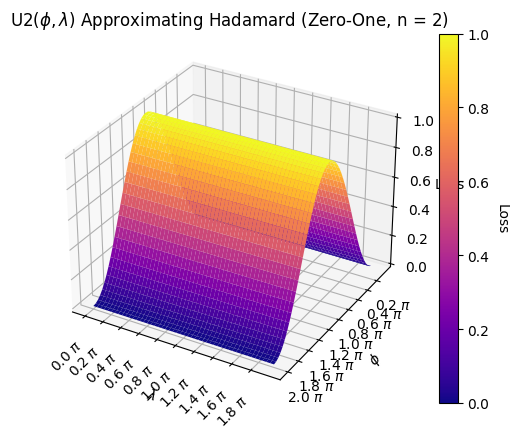

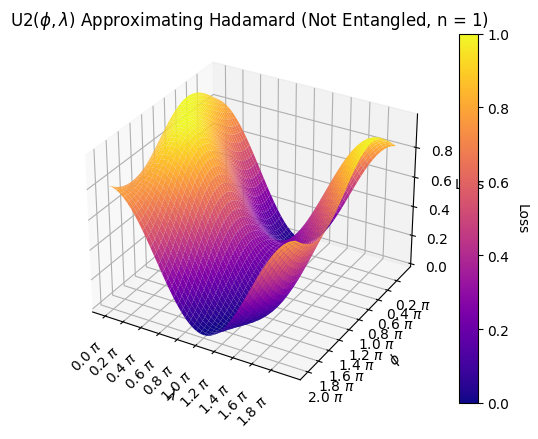

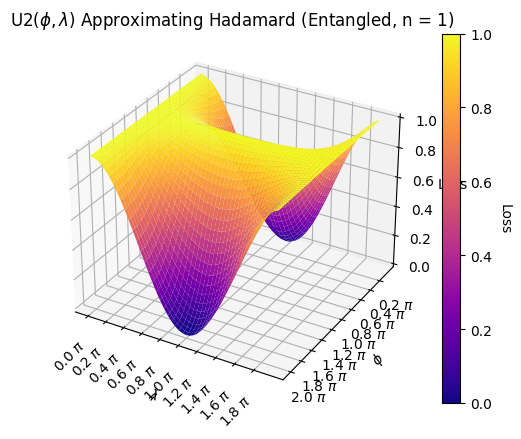

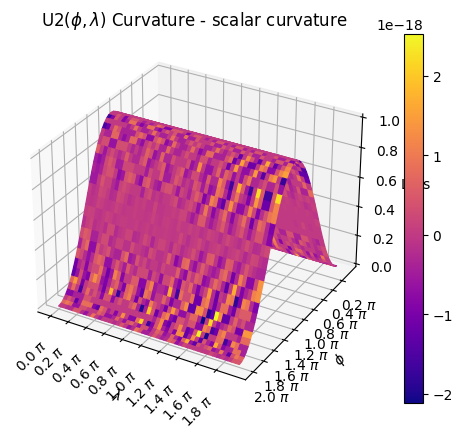

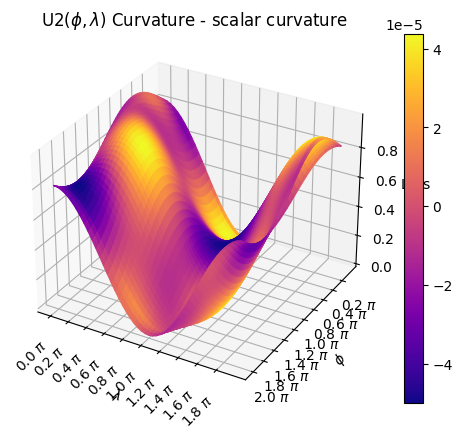

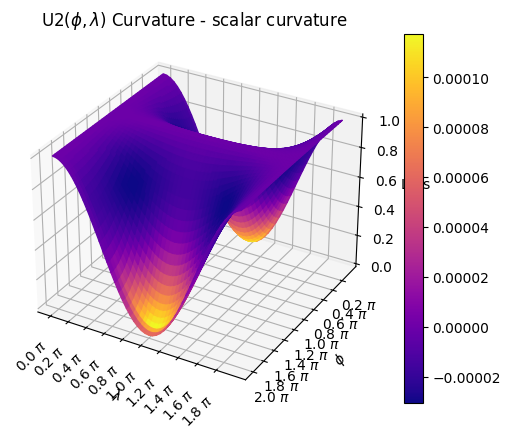

In [6]:
# EXP on Hadamard
run_hadamard()

In [ ]:
# EXP on Pauli-X
run_pauli_x()

In [ ]:
# EXP on Pauli-Y
run_pauli_y()

In [ ]:
# EXP on Pauli-Z
run_pauli_z()

In [ ]:
# EXP on Phase (S)
run_phase_s()